In [1]:
#math and linear algebra stuff
import numpy as np
import numpy.linalg as la

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
#mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Estimating ellipsoid from data

This notebook intends to presents a few simple ways to find the n-dimensional ellipsoid or the n-dimensional gaussian that best fit a set of data points.

## Introduction : from balls to ellipsoid

Ellipsoid are funny mathematical objects, more precisely, they are geometrical constructions in euclidean spaces like $\mathbb{R}^n$ that are closely related to symmetric matrices and quadratic forms.

Most of people know about the concept of euclidean ball, or sphere, which can easily be extended in n-dimensions as $l_2$-ball or hypersphere, whose later definition is, in $ \mathbb{R}^n$:
$$
    x \in \mathbb{R}^n \; \text{ such that} \; \sqrt{ \sum_{i=0}^{n-1} x_i^2 } = r
$$
Where $r\geq 0$ is called the radius.<br>
We can recognize the definition of the $l_2$ norm in this expression, and directly write:
$$
    x \in \mathbb{R}^n \; \text{ such that} \; \|x\|_2 = r
$$

(-1.0, 1.0, -1.0, 1.0)

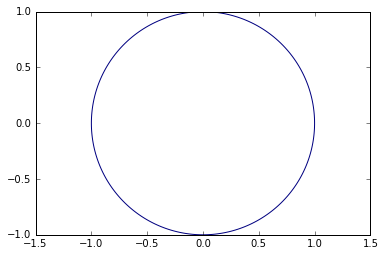

In [2]:
x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x,y)

#Let's draw a circle of equation \sqrt{X^2 + Y^2} -1 = 0
C = np.sqrt(X**2 + Y**2) - 1
plt.contour(X,Y,C,[0])
plt.axis('equal')

One can now generalize the concept of distance in euclidean space, through Hilbert spaces in finite dimension using specific definition of inner product.

For instance, we can rewrite the norm $\|\|_2$ as $\|\|_{M_I}$ where $M_I$ is the identity matrix of size $n\times n$:
$$
M_I =
\begin{pmatrix}
    1 & 0 & \dots & 0\\
    0 & 1 & \ddots & \vdots\\
    \vdots & \ddots & \ddots & 0 \\
    0 & \dots & 0 & 1
\end{pmatrix}
$$

Using this notation, $\|x\|_{M_I}$ can be computed as $\sqrt{x^{\intercal} M_I x}$

One can scale the diagonal elements of $M_I$ so that overall norm will grow faster for some coordinates, in this case, the corresponding ball will be more constrained in that direction, let's take a simple 2D example:

$$
M_{aniso} =
\begin{pmatrix}
    1 & 0\\
    0 & 4
\end{pmatrix}
$$

Which give the following ball equation:
\begin{align*}
    \sqrt{x^{\intercal} M_{aniso} x} = 1\\
    \sqrt{x_1^2 + 4 x_2^2} -1 = 0
\end{align*}

Where of course, the length of the semi-axis will be $\frac{1}{\sqrt{1}}=1$ along $x_1$ (when $x_2=0$) and $\frac{1}{\sqrt{4}}=\frac{1}{2}$ along $x_2$ (when $x_1 = 0$)

(-1.0, 1.0, -1.0, 1.0)

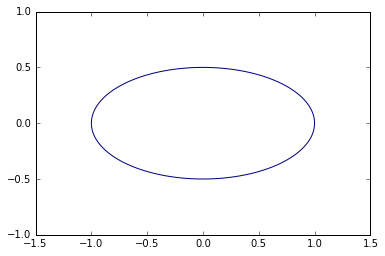

In [3]:
#Let's draw an axis aligned ellipsis of equation \sqrt{x^t Maniso x} -1 = 0

#Define Maniso, then linearize the meshgrid for matrix-vector product
Maniso = np.array([[1,0],[0,4]])
xvec = [np.reshape(X,X.size),np.reshape(Y,Y.size)]

#plot contour of \sqrt{x^t Maniso x} -1 = 0
test=np.dot(Maniso,xvec)
E=np.sqrt(np.sum(test*xvec,0))-1

plt.contour(X,Y,np.reshape(E,X.shape),[0])
plt.axis('equal')

## Positive semi-definite matrix
Nice, the ellipsis is indeed more constrained along the $y$ direction. But what about the $M$ matrix that defines the self dot poduct used in the norm calculation ? Can we choose it randomly ?

Of course not, $M$ should be positive semi definite (PSD), so that the square root can be applied to the result of $x^{\intercal}Mx \succeq 0$. Unfortunately, positive semi definite is a rather abstract definition for a matrix, some even call it a convex cone which is even more abstract.

There are numerous example of PSD matrices:
- symmetric dyads $uu^{\intercal}$, PSD is easily provable because $x^{\intercal}uu^{\intercal}x = (u^{\intercal}x)^2 \geq 0$
- self product of matrix $M^{\intercal}M$, PSD i given by $x^{\intercal}M^{\intercal}Mx = (Mx)^2 \geq 0$
- Covariance matrix
- Gram matrix
- Laplacian matrix of a graph, see the notebook about Spectral gaph theory
- ...

Although not all PSD matrices are symmetric, all matrices cited here are symmetric and PSD, and in general symmetric matrices are PSD, and can be diagonalized in an orthonormal basis, whose matrix is called orthonormal aka unitary, aka rotation matrix.

This last assertion (that can be easily proven TODO) is very important, because it means geometrically that every symmetric matrix, can be expressed as an axis aligned dilation in a given rotated basis.

See for instance this simple 2D example that uses the previous dilation, and a rotation matrix $M_{rot}$ by angle $\theta = \frac{\pi}{8}$ :
$$
M_{rot} =
\begin{pmatrix}
    cos(\theta) & -sin(\theta)\\
    sin(\theta) & cos(\theta)
\end{pmatrix}
$$
In order to generate a PSD of the form:
\begin{align*}
    M_{anisorot} &= M_{rot} M_{aniso} M_{rot}^{\intercal} \\
    &= \begin{pmatrix}
            cos(\theta) & -sin(\theta)\\
            sin(\theta) & cos(\theta)
        \end{pmatrix}
        \begin{pmatrix}
            1 & 0\\
            0 & 4
        \end{pmatrix}
        \begin{pmatrix}
            cos(\theta) & sin(\theta)\\
            -sin(\theta) & cos(\theta)
        \end{pmatrix}
\end{align*}

(-1.0, 1.0, -1.0, 1.0)

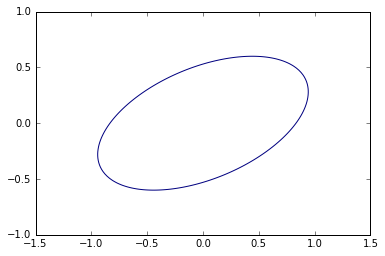

In [4]:
#define the rotation matrix:
theta = np.pi/8.
Mrot = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

#compute the rotation/dilation/inverse rotation matrix Manisorot = Mrot Maniso Mrot^t
Manisorot = np.dot(Maniso,Mrot.T)
Manisorot = np.dot(Mrot,Manisorot)

#plot contour of \sqrt{x^t Manisorot x} -1 = 0
test=np.dot(Manisorot,xvec)
E=np.sqrt(np.sum(test*xvec,0))-1

plt.contour(X,Y,np.reshape(E,X.shape),[0])
plt.axis('equal')

### Quadratic form

The matrix definition of an ellipsoid : $x^{\intercal}Mx$ can obviously be developped, and give a polynomial of degree 2 of the form
$$
\sum_{i=0, j=0}^{n-1, n-1} M_{ij} x_i x_j
$$

This sum has $n^2$ terms, but, as all $M_{ij}$ and $M_{ji}$ terms can be factorized, the underlying quadratic form actually has $\frac{n \times (n-1)}{2}$ terms. Unfortunately, we won't talk much about quadratic forms here.

### Ellipsoid volume

When studying the determinant of a matrix, it is always interesting to see this scalar as the volume of the hyperparallelogram described by the column vector of this matrix.
Determinant somehow describes the volume dilation applied to the unitary hypercube (identity matrix) when multiplied by the matrix.

In the case of the Ellipsoid, the matrix coefficients, describes the force of the $l_2$ norm constraints, and it is actually the inverse of this matrix that caracterize the dilation behaviour.

The inherent volume dilation can then be computed as the determinant of the inverse of the ellipsoid matrix.

We can then write, for an ellipsoid of matrix $M$ in $\mathbb{R}^n$ its volume $V_M$ as the product of the volume of the unit ball in $\mathbb{R}^n$ times $det(M^{-1})$.
First, we recall that the volume $V^n(r)$ of the the $l_2$ ball in $\mathbb{R}^n$ is
$$
    V^n(r) =\frac{\pi^{n/2}r^{n}}{\Gamma \left({\frac{n}{2}}+1\right)}
$$
Which gives
$$
    V_M = \frac{\pi^{n/2}}{\Gamma \left({\frac{n}{2}}+1\right)} \times det(M^{-1})
$$

### Minimizing the ellipsoid volume

Boyd & Vandenberghe showed some interesting results about PSD matrix optimization, in their book "convex optimization". One of the application is related to the log determinant minimization (p92):

We consider $f(X) = log( det( X^{-1}) )$ on $S_n^{++}$ the set of PD matrices, the convex conjugate function is defined as
$$
    f^*(Y) = \underset{X\succ 0}{sup} \quad tr(YX)+log( det(X) )
$$
this results from the fact that $tr(YX)$ is the standard inner product on $S^n$.
The development are beyond the scope of this notebook, but they managed to show that
$$
    f^*(Y) = log(det(-Y)^{-1})
$$

### Minimum covering ellipsoid

Now that we have some theoretical tool, it is easy to derive the so-called minimum covering ellipsoid problem (MCE) or minimum volume enclosing ellipsoid MVEE.

Suppose that we have a set of points $p_i \in \mathbb{R}^n, 0\leq i\leq m-1$, and that we want to find the ellipsoid M, centered in $c$, such that all $p_i$ are enclosed in $M$.<br>
This problem can easily be written as:

\begin{align*}
    \text{minimize} \quad & f_0(X) = log( det(M^{-1}))\\
    \text{subject to} \quad & (p_i-c)^{\intercal}M(p_i-c) \leq 1, \quad i=0,...,m-1
\end{align*}

Khachiyan designed an algorithm to find the solution of this optimization problem, we reproduced hereafter

In [7]:
def mvee(points, tol = 0.001):
    """
    Find the minimum volume ellipse.
    Return A, c where the equation for the ellipse given in "center form" is
    (x-c).T * A * (x-c) = 1
    """
    points = np.asmatrix(points)
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T
    err = tol+1.0
    u = np.ones(N)/N
    while err > tol:
        # assert u.sum() == 1 # invariant
        X = Q * np.diag(u) * Q.T
        M = np.diag(Q.T * la.inv(X) * Q)
        jdx = np.argmax(M)
        step_size = (M[jdx]-d-1.0)/((d+1)*(M[jdx]-1.0))
        new_u = (1-step_size)*u
        new_u[jdx] += step_size
        err = la.norm(new_u-u)
        u = new_u
    c = u*points
    A = la.inv(points.T*np.diag(u)*points - c.T*c)/d    
    return np.asarray(A), np.squeeze(np.asarray(c))

(0.5, 3.0, 0.0, 3.0)

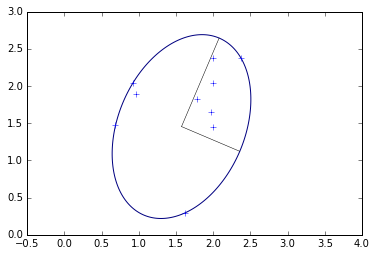

In [18]:
#We will choose some random gaussian distributed 2D points
NB_POINTS = 50
P = np.random.multivariate_normal([2,2],la.inv(Manisorot),NB_POINTS)

#Solve MVEE
A,c = mvee(P, tol = 1e-3)
c=c.reshape((2,1))

#define a new grid
e,v = la.eig(A)
idx = e.argsort()[::-1] #sort values from highest to lowest

#longest and shortest semi axis
e=1/np.sqrt(e)
a=e[idx[0]]
b=e[idx[1]]

#consider largest axe - associated with first eigenvalue
angle = np.arctan2(v[1,idx[0]],v[0,idx[0]])

#plot semi axes
plt.plot([c[0],c[0]+a*v[0,idx[0]]],[c[1],c[1]+a*v[1,idx[0]]], 'k-', lw=0.5)
plt.plot([c[0],c[0]+b*v[0,idx[1]]],[c[1],c[1]+b*v[1,idx[1]]], 'k-', lw=0.5)

#Compute AABB - X
maxT1=np.arctan(-(b/a)*np.tan(angle))
maxT2=maxT1+np.pi
val1=a*np.cos(angle)*np.cos(maxT1)-b*np.sin(angle)*np.sin(maxT1)
val2=a*np.cos(angle)*np.cos(maxT2)-b*np.sin(angle)*np.sin(maxT2)
minX = np.minimum(val1,val2)+c[0]
maxX = np.maximum(val1,val2)+c[0]
#Compute AABB - Y
maxT1=np.arctan(b/(a*np.tan(angle)))
maxT2=maxT1+np.pi
val1=a*np.sin(angle)*np.cos(maxT1)+b*np.cos(angle)*np.sin(maxT1)
val2=a*np.sin(angle)*np.cos(maxT2)+b*np.cos(angle)*np.sin(maxT2)
minY = np.minimum(val1,val2)+c[1]
maxY = np.maximum(val1,val2)+c[1]

#Generate meshgrid over AABB
x = np.linspace(minX, maxX, 100)
y = np.linspace(minY, maxY, 100)
X, Y = np.meshgrid(x,y)
xvec = np.array([np.reshape(X,X.size),np.reshape(Y,Y.size)])

#plot contour of \sqrt{(p-c)^t A (p-c)} -1 = 0
test=np.dot(A,xvec-c)
E=np.sqrt(np.sum(test*(xvec-c),0))-1

plt.plot(P[:,0],P[:,1], '+')
plt.contour(X,Y,np.reshape(E,X.shape),[0])
plt.axis('equal')

### Multivariate gaussian distribution and soft ellipsoid